# Ambiente

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import ssl
import datetime, pytz

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 1000)
pd.set_option('display.expand_frame_repr', True)

# Funções uteis

In [3]:
def dateparse (time_in_secs):
  '''funcao que converte o dado do tipo unix timestamp no arquivo csv para o formato datetime local'''

  timezone = pytz.timezone('America/Sao_Paulo')
  return timezone.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


In [4]:
na_values = r'\?|nan|-' # verificar a necessidade de complementar com mais opções

def null_as_string(df, nan_values = na_values):
  '''funcao que verifica se as colunas possuem algum registro representativo de valores ausentes como strings'''

  cols_na = []
  for nome_coluna in df.select_dtypes(include=['O']).columns:
      teste_na = df[nome_coluna].str.fullmatch(nan_values, na=False, case=False).any()
      if teste_na:
        cols_na.append(nome_coluna)
      print(f'{nome_coluna}{" "*(20-len(nome_coluna))} contem - {teste_na}')

  return cols_na
  

# Leitura dos dados

https://www.cryptodatadownload.com/data/bitstamp/

In [5]:
ssl._create_default_https_context = ssl._create_unverified_context

filepath_daily='https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv'
filepath_hourly='https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_1h.csv'

In [6]:
df = pd.read_csv(filepath_daily, skiprows=1, parse_dates=[0], date_parser=dateparse) 

In [7]:
# historico de observacoes no dataset
pd.to_datetime(df.iloc[0,1]) - pd.to_datetime(df.iloc[-1,1])

Timedelta('2645 days 00:00:00')

In [8]:
# data mais antiga
print('Data mais antiga no dataset: ', df.iloc[-1,1])

Data mais antiga no dataset:  2014-11-28 00:00:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646 entries, 0 to 2645
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype                            
---  ------      --------------  -----                            
 0   unix        2646 non-null   datetime64[ns, America/Sao_Paulo]
 1   date        2646 non-null   object                           
 2   symbol      2646 non-null   object                           
 3   open        2646 non-null   float64                          
 4   high        2646 non-null   float64                          
 5   low         2646 non-null   float64                          
 6   close       2646 non-null   float64                          
 7   Volume BTC  2646 non-null   float64                          
 8   Volume USD  2646 non-null   float64                          
dtypes: datetime64[ns, America/Sao_Paulo](1), float64(6), object(2)
memory usage: 186.2+ KB


Sobre cada coluna:

- Unix Timestamp - This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone
- Date - This timestamp is UTC Timezone
- Symbol - The symbol for which the timeseries data refers
- Open - This is the opening price of the time period
- High - This is the highest price of the time period
- Low - This is the lowest price of the time period
- Close - This is the closing price of the time period
- Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount
- Volume Base Ccy - This is the volume in the base/converted ccy. Ie. For BTC/USDT, this is in USDT amount

### verificação de valores ausentes

In [10]:
# mostra apenas as colunas com valores nulos
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [11]:
# Verificando se as colunas possuem algum registro representativo de valores ausentes como strings
cols_na = null_as_string(df)

date                 contem - False
symbol               contem - False


### Enriquecendo o dataset com novos atributos

Calculando volume médio de acordo com o volume USD e a quantidade de bitcoins

In [12]:
df['Convert_BTCUSD'] = df['Volume BTC']/df['Volume USD']
df['Convert_USDBTC'] = df['Volume USD']/df['Volume BTC']
df['Right_converter'] = df.apply(lambda x: x['Convert_BTCUSD'] if x['Convert_BTCUSD']>1 else x['Convert_USDBTC'], axis=1)

O fator de conversão mudou a partir de fev/2018

In [13]:
display(df.head(4))

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,Convert_BTCUSD,Convert_USDBTC,Right_converter
0,2022-02-24 00:00:00-03:00,2022-02-24 00:00:00,BTC/USD,37253.26,37444.13,37122.74,37259.51,11.650079,4.340763e+05,0.000027,37259.51,37259.51
1,2022-02-23 00:00:00-03:00,2022-02-23 00:00:00,BTC/USD,38269.94,39303.24,37060.16,37274.18,1778.275258,6.628375e+07,0.000027,37274.18,37274.18
2,2022-02-22 00:00:00-03:00,2022-02-22 00:00:00,BTC/USD,37036.98,38463.88,36368.99,38269.94,2388.759035,9.141766e+07,0.000026,38269.94,38269.94
3,2022-02-21 00:00:00-03:00,2022-02-21 00:00:00,BTC/USD,38384.09,39494.11,36810.72,37076.60,3501.420364,1.298208e+08,0.000027,37076.60,37076.60


Verificando o desvio entre o valor de fechamento e a média calculada, para ver se a lógica funcionou

In [14]:
df['bias'] = (df['Right_converter']-df['close'])/df['close']

In [15]:
print('Bias: [', df['bias'].min(), df['bias'].max(),']')

Bias: [ -0.11210170087872764 0.18101524520919396 ]


### Análide Gráfica inicial

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# sns.set_theme(style="white", rc={"axes.facecolor": "white"})

In [17]:
# Tornando a coluna 'unix' com índice
df.set_index('unix', drop=True, inplace=True)

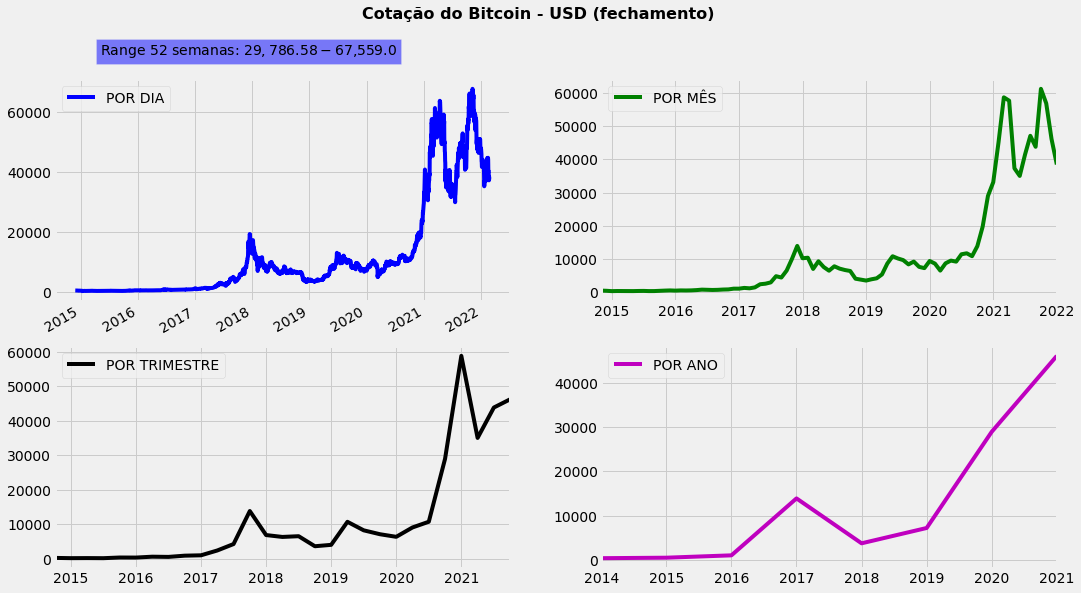

In [18]:
fig, axes = plt.subplots(2,2, figsize=(16,10))
fig.suptitle('Cotação do Bitcoin - USD (fechamento)', fontsize=16, fontweight=600)

df['close'].plot(ax=axes[0,0], color='b', label='POR DIA', legend=True)
df['close'].asfreq('M').plot(ax=axes[0,1], color='g', label='POR MÊS', legend=True)
df['close'].asfreq('Q').plot(ax=axes[1,0], color='k', label='POR TRIMESTRE', legend=True)
df['close'].asfreq('Y').plot(ax=axes[1,1], color='m', label='POR ANO', legend=True)

axes[0,0].text(0.1, 80000, f'Range 52 semanas: ${min(df["close"].iloc[0:52*7]):,} - ${max(df["close"].iloc[0:52*7]):,}', va='center', ha="left", 
          bbox=dict(facecolor="b",alpha=0.5),
          transform=axes[0,0].get_yaxis_transform())

for ax in axes.flat:
  ax.set_xlabel(None)

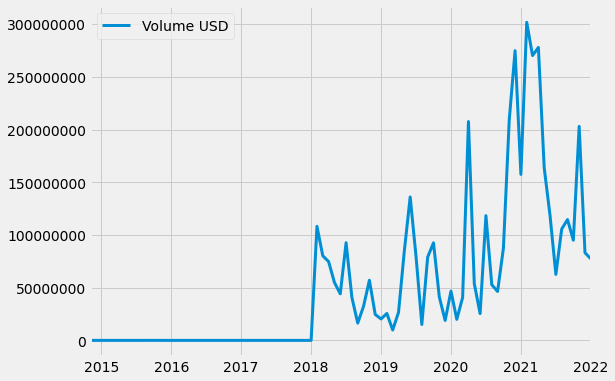

In [19]:
# Volume
ax = df["Volume USD"].asfreq('M').plot(lw=3, label='Volume USD', legend=True, figsize=(8,6))
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel(None);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


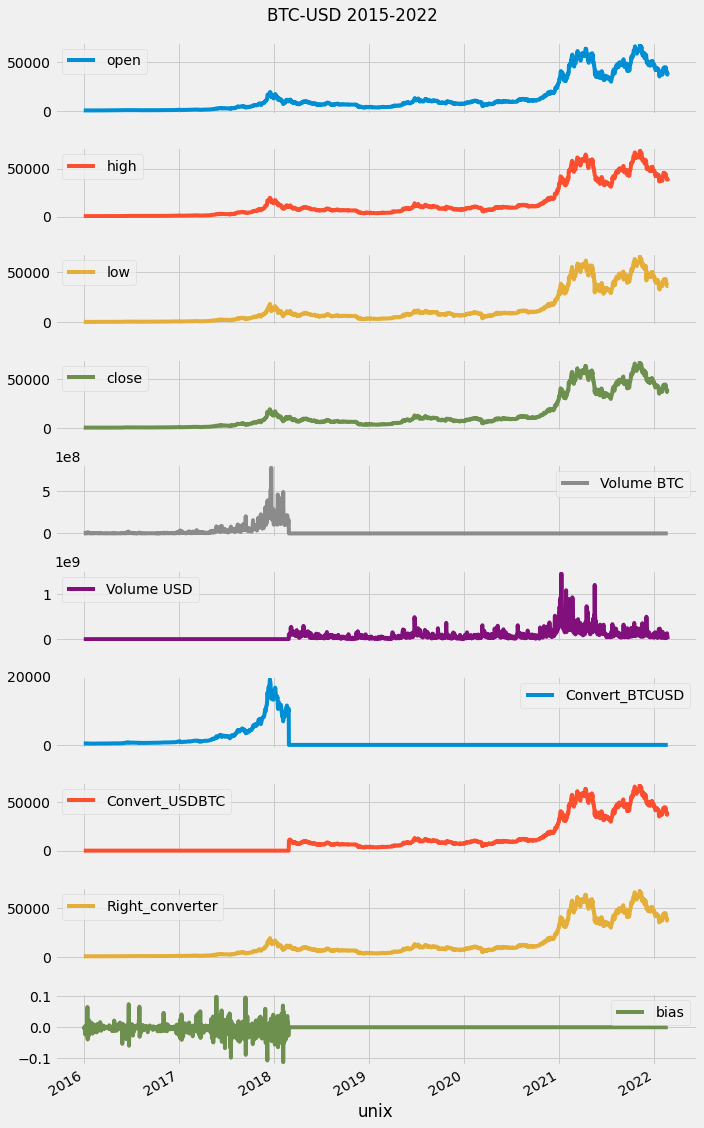

In [20]:
ax = df['2015':].plot(subplots=True, figsize=(10,16), title='BTC-USD 2015-2022')[0]
fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

___

In [21]:
!pip install --upgrade mplfinance

In [22]:
import mplfinance as mpf

In [23]:
df_mpf = df.drop(columns=['date','symbol']).copy()
df_mpf.index.name = 'Date'
df_mpf.rename(columns={'Volume USD': 'volume'}, inplace=True)
df_mpf = df_mpf.reindex(index=df_mpf.index[::-1])



*gráfico de [candlestick](https://pt.wikipedia.org/wiki/Candlestick) com médias móveis de 7 dias, 15 dias e 30 dias, e volume em USD*

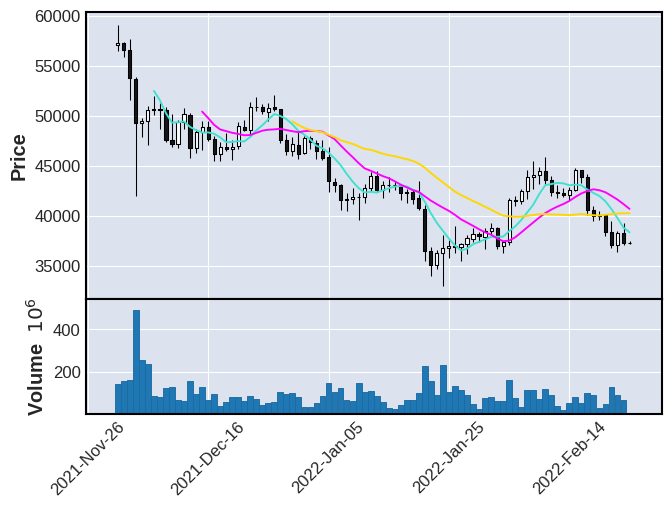

In [24]:
mpf.plot(df_mpf['2021-12':], type='candle', mav=(7,15,30), volume=True, show_nontrading=True, warn_too_much_data=2500)

___
**MACD** plot (**M**oving **A**verage **C**onvergence **D**ivergence)

- É um oscilador que analisa a convergência e divergência entre duas médias móveis para tentar identificar tendências de preço. É composto por uma linha e seu sinal, além de um histograma.
- Cruzamentos da linha com seu sinal podem indicar uma tendência de alta, porém se o sinal estiver acima da linha do MACD, pode ser um indicador de tendência de baixa.
- O histograma também pode ser utilizado para antever mudança de tendências: quando ele cruza do negativo para positivo ou vice-versa, há uma indicação de que uma possível mudança de tendência está por vir.

In [25]:
# calculando as médias móveis exponenciais de 12 e 26 períodos
exp12 = df_mpf['2021-12':]['close'].ewm(span=12, adjust=False).mean()
exp26 = df_mpf['2021-12':]['close'].ewm(span=26, adjust=False).mean()

A Linha MACD é definida como a diferença entre essas duas médias móveis

In [26]:
macd = exp12 - exp26

O Sinal MACD é definido como a média móvel exponencial de 9 períodos da Linha MACD.

Também calculamos a diferença entre a Linha MACD e o Sinal MACD, que plotaremos como um histograma.

In [27]:
signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

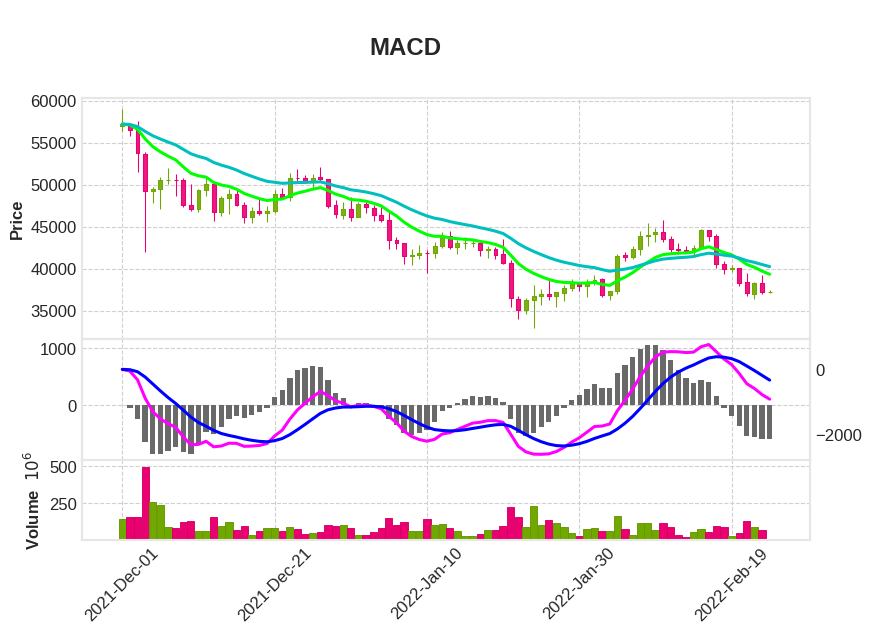

In [28]:
# MACD plot
apds = [mpf.make_addplot(exp12,color='lime'),
        mpf.make_addplot(exp26,color='c'),
        mpf.make_addplot(histogram,type='bar',width=0.7,panel=1,
                         color='dimgray',alpha=1,secondary_y=False),
        mpf.make_addplot(macd,panel=1,color='fuchsia',secondary_y=True),
        mpf.make_addplot(signal,panel=1,color='b',secondary_y=True),
       ]

mpf.plot(df_mpf['2021-12':],type='candle',addplot=apds,figscale=1.1,figratio=(8,5),title='\nMACD',
         style='binance',volume=True,volume_panel=2,panel_ratios=(6,3,2), warn_too_much_data=2500)